# Загрузка датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [3]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data.head()

Date     Time   Usage_kWh
0 2017-01-01  00 - 01  570.685479
1 2017-01-01  01 - 02  604.642705
2 2017-01-01  02 - 03  518.732113
3 2017-01-01  03 - 04  608.188829
4 2017-01-01  04 - 05  714.140572

In [4]:
data.tail()

Date     Time    Usage_kWh
35059 2020-12-31  19 - 20  1093.896979
35060 2020-12-31  20 - 21   976.242006
35061 2020-12-31  21 - 22   960.551132
35062 2020-12-31  22 - 23   694.074945
35063 2020-12-31  23 - 00   801.715216

In [5]:
y_test = data.iloc[-24*7:]['Usage_kWh'].values

In [6]:
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [152]:
df_results = pd.DataFrame(None,
                      columns=['Model', 'Tuner', 'Params',
                               'MAPE', 'MSE', 'MAE', 'R2', #'Sum',
                               'Training_time', 'Tuner_time', 'Time_prediction'])
df_predictions = pd.DataFrame(None)
df_predictions['True'] = y_test

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

def r2(y_true, y_pred):
    ssres = sum((y_true-y_pred)**2)
    sstotal = sum((y_true-np.mean(y_true))**2)
    return 1 - ssres/sstotal

In [154]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])

# DecisionTree

In [155]:
model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [156]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [157]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [158]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0  DecisionTree(Наблюдение за раз)  False   

                                              Params      MAPE           MSE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.04699  28393.766823   

          MAE        R2  Training_time Tuner_time  Time_prediction  
0  127.460416  0.755416      20.022319       None         0.022014

In [159]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

In [160]:
model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [161]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [162]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [163]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0  DecisionTree(Наблюдение за раз)  False   
1       DecisionTree(Сутки за раз)  False   

                                              Params       MAPE           MSE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990  28393.766823   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943  43231.052166   

          MAE        R2  Training_time Tuner_time  Time_prediction  
0  127.460416  0.755416      20.022319       None         0.022014  
1  150.975916  0.627608      28.373121       None         0.001998

In [164]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24*7])

In [165]:
model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [166]:
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

In [167]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0  DecisionTree(Наблюдение за раз)  False   
1       DecisionTree(Сутки за раз)  False   
2      DecisionTree(Неделя за раз)  False   

                                              Params       MAPE           MSE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990  28393.766823   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943  43231.052166   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834  24103.124465   

          MAE        R2  Training_time Tuner_time  Time_prediction  
0  127.460416  0.755416      20.022319       None         0.022014  
1  150.975916  0.627608      28.373121       None         0.001998  
2  112.161936  0.792376     170.405692       None         0.001000

In [168]:
dates_list = []
for d in data[-24*7:]['Date']:
    if d not in dates_list:
        dates_list.append(d)

In [169]:
dates_list

[Timestamp('2020-12-25 00:00:00'),
 Timestamp('2020-12-26 00:00:00'),
 Timestamp('2020-12-27 00:00:00'),
 Timestamp('2020-12-28 00:00:00'),
 Timestamp('2020-12-29 00:00:00'),
 Timestamp('2020-12-30 00:00:00'),
 Timestamp('2020-12-31 00:00:00')]

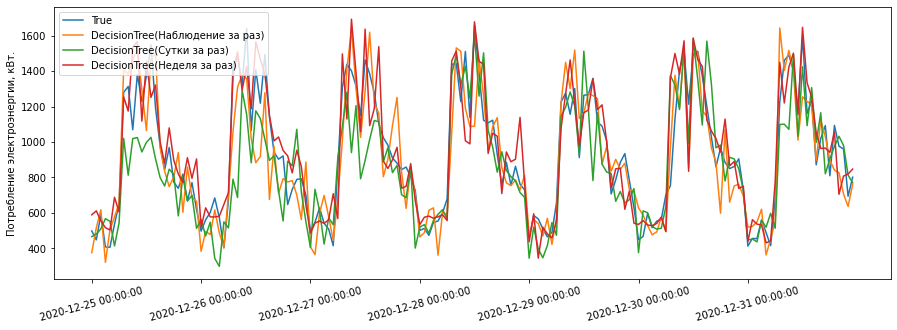

In [170]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [171]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

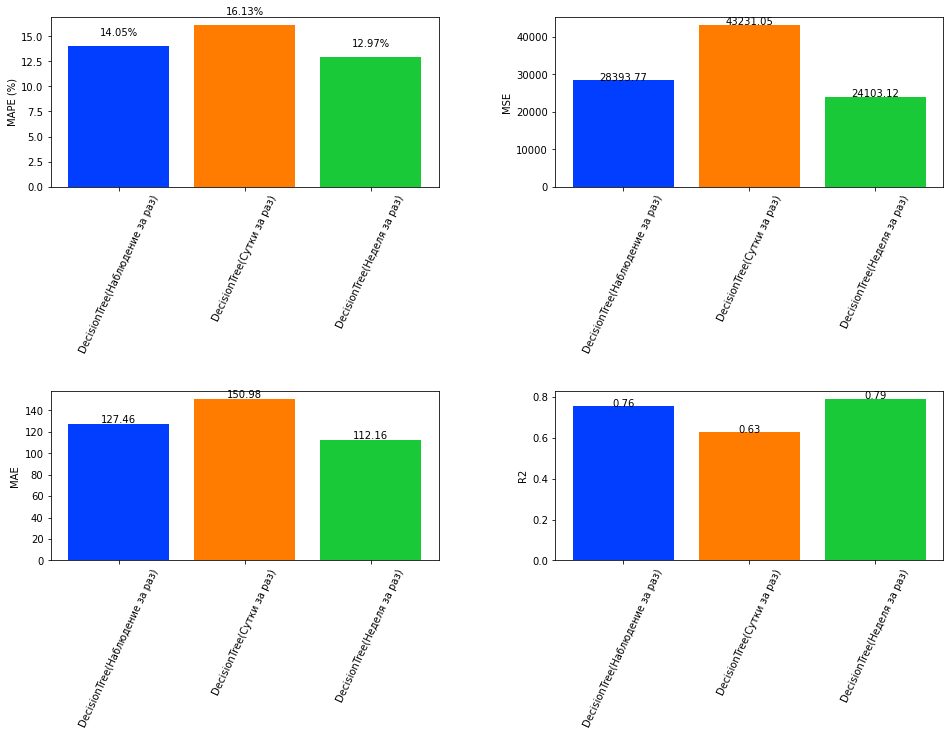

In [172]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Random Forest

In [173]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'


# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW])
    
model_name = 'RandomForest'
params = {'n_estimators':100,
          'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0  DecisionTree(Наблюдение за раз)  False   
1       DecisionTree(Сутки за раз)  False   
2      DecisionTree(Неделя за раз)  False   
3  RandomForest(Наблюдение за раз)  False   

                                              Params       MAPE           MSE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990  28393.766823   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943  43231.052166   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834  24103.124465   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245  12282.000441   

          MAE        R2  Training_time Tuner_time  Time_prediction  
0  127.460416  0.755416      20.022319       None         0.022014  
1  150.975916  0.627608      28.373121       None         0.001998  
2  112.161936  0.792376     170.405692       None         0.001000  
3   81.881064  0.894203     962.175953       None         1.390336

In [174]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0  DecisionTree(Наблюдение за раз)  False   
1       DecisionTree(Сутки за раз)  False   
2      DecisionTree(Неделя за раз)  False   
3  RandomForest(Наблюдение за раз)  False   
4       RandomForest(Сутки за раз)  False   

                                              Params       MAPE           MSE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990  28393.766823   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943  43231.052166   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834  24103.124465   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245  12282.000441   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.469093  17413.969416   

          MAE        R2  Training_time Tuner_time  Time_prediction  
0  127.460416  0.755416      20.022319       None         0.022014  
1  150.975916  0.627608      28.373121       None         0.001998  
2  112.161936  0.792376     170.405692       None         0.001000  
3   81.881064  0.894203     962.175953       None         1.390336  
4   96.522142  0.849996    1976.314166       None         0.171177

In [175]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24*7])
    
model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()
    
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

KeyboardInterrupt: 

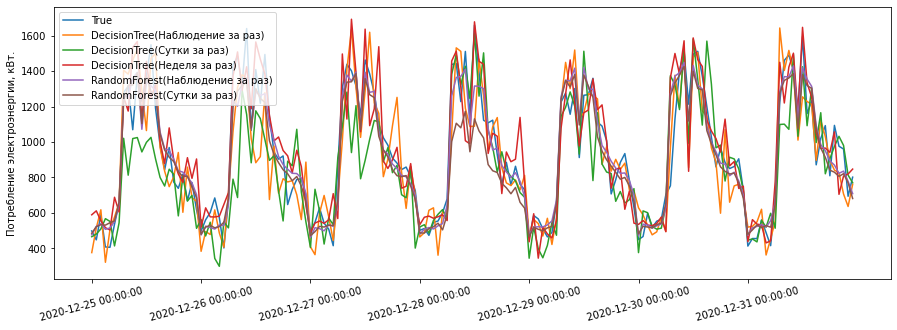

In [192]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [203]:
df_predictions.head()

True  DecisionTree(Наблюдение за раз)  DecisionTree(Сутки за раз)  \
0  498.574076                       376.254520                  466.003532   
1  448.325927                       515.626851                  480.716646   
2  589.959784                       617.725826                  509.776000   
3  408.063429                       321.717925                  567.784911   
4  406.263067                       506.053615                  552.295560   

   DecisionTree(Неделя за раз)  RandomForest(Наблюдение за раз)  \
0                   589.542480                       476.669955   
1                   611.832702                       523.687279   
2                   555.603611                       539.426103   
3                   516.897256                       507.646790   
4                   503.904770                       515.224523   

   RandomForest(Сутки за раз)  
0                  485.146663  
1                  522.738750  
2                  533.578030  
3                  531.261531  
4                  544.928026

In [201]:
df_results

Model  Tuner  \
0  DecisionTree(Наблюдение за раз)  False   
1       DecisionTree(Сутки за раз)  False   
2      DecisionTree(Неделя за раз)  False   
3  RandomForest(Наблюдение за раз)  False   
4       RandomForest(Сутки за раз)  False   

                                              Params       MAPE           MSE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990  28393.766823   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943  43231.052166   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834  24103.124465   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245  12282.000441   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.469093  17413.969416   

          MAE        R2  Training_time Tuner_time  Time_prediction  
0  127.460416  0.755416      20.022319       None         0.022014  
1  150.975916  0.627608      28.373121       None         0.001998  
2  112.161936  0.792376     170.405692       None         0.001000  
3   81.881064  0.894203     962.175953       None         1.390336  
4   96.522142  0.849996    1976.314166       None         0.171177

In [199]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

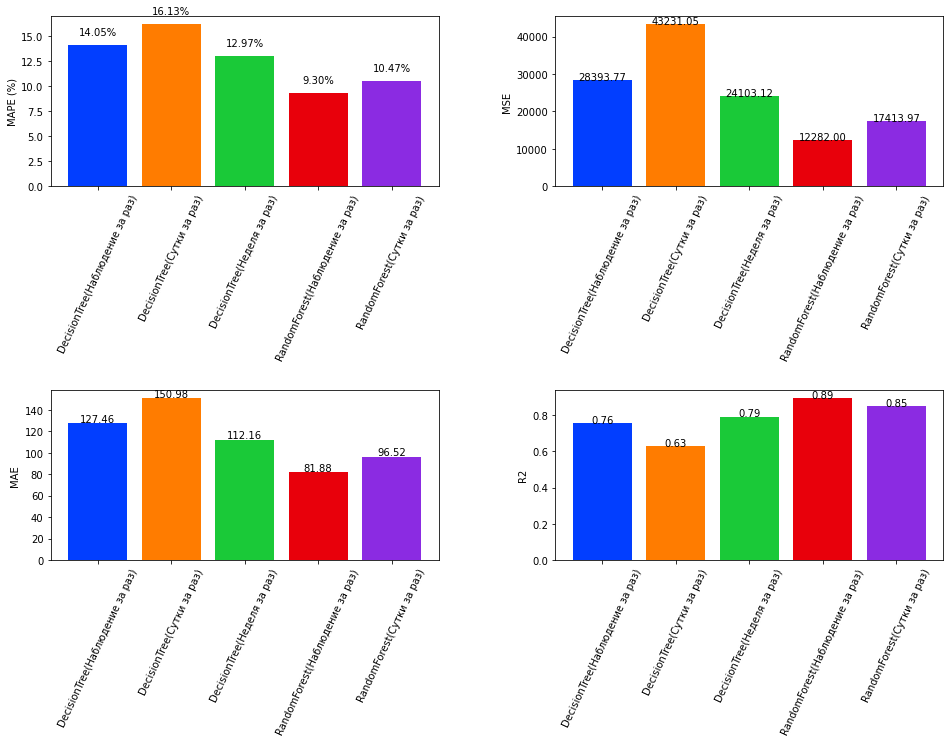

In [200]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Стандартизация

# DecisionTree

In [204]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW]-np.mean(y))/np.std(y))

In [205]:
model_name = 'DecisionTree (стандартизация)'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [206]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [207]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [208]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0                   DecisionTree(Наблюдение за раз)  False   
1                        DecisionTree(Сутки за раз)  False   
2                       DecisionTree(Неделя за раз)  False   
3                   RandomForest(Наблюдение за раз)  False   
4                        RandomForest(Сутки за раз)  False   
5  DecisionTree (стандартизация)(Наблюдение за раз)  False   

                                              Params       MAPE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.469093   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  50.282337   

             MSE         MAE        R2  Training_time Tuner_time  \
0   28393.766823  127.460416  0.755416      20.022319       None   
1   43231.052166  150.975916  0.627608      28.373121       None   
2   24103.124465  112.161936  0.792376     170.405692       None   
3   12282.000441   81.881064  0.894203     962.175953       None   
4   17413.969416   96.522142  0.849996    1976.314166       None   
5  161755.224270  334.300832 -0.393359      13.456223       None   

   Time_prediction  
0         0.022014  
1         0.001998  
2         0.001000  
3         1.390336  
4         0.171177  
5         0.027239

In [209]:
WINDOW = 24*7
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW:i+WINDOW+24]-np.mean(y))/np.std(y))

In [210]:
# model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [211]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [212]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [213]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0                   DecisionTree(Наблюдение за раз)  False   
1                        DecisionTree(Сутки за раз)  False   
2                       DecisionTree(Неделя за раз)  False   
3                   RandomForest(Наблюдение за раз)  False   
4                        RandomForest(Сутки за раз)  False   
5  DecisionTree (стандартизация)(Наблюдение за раз)  False   
6       DecisionTree (стандартизация)(Сутки за раз)  False   

                                              Params       MAPE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.469093   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  50.282337   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  76.122607   

             MSE         MAE        R2  Training_time Tuner_time  \
0   28393.766823  127.460416  0.755416      20.022319       None   
1   43231.052166  150.975916  0.627608      28.373121       None   
2   24103.124465  112.161936  0.792376     170.405692       None   
3   12282.000441   81.881064  0.894203     962.175953       None   
4   17413.969416   96.522142  0.849996    1976.314166       None   
5  161755.224270  334.300832 -0.393359      13.456223       None   
6  398747.332232  495.601467 -2.434809      46.887068       None   

   Time_prediction  
0         0.022014  
1         0.001998  
2         0.001000  
3         1.390336  
4         0.171177  
5         0.027239  
6         0.000000

In [214]:
WINDOW = 24*7
Forecast_type = 'Неделя за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*14):
    X_train.append((y[i:i+WINDOW]-np.mean(y))/np.std(y))
    y_train.append((y[i+WINDOW:i+WINDOW+24*7]-np.mean(y))/np.std(y))

In [215]:
#model_name = 'DecisionTree'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [216]:
y_pred = []
X_for_prediction = y[-24*7:]
start_prediction = time.time()
y_pred = model.predict(X_for_prediction.reshape(-1, 24*7))[0]
end_prediction = time.time()
y_pred = [x * np.std(y) + np.mean(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

In [217]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0                   DecisionTree(Наблюдение за раз)  False   
1                        DecisionTree(Сутки за раз)  False   
2                       DecisionTree(Неделя за раз)  False   
3                   RandomForest(Наблюдение за раз)  False   
4                        RandomForest(Сутки за раз)  False   
5  DecisionTree (стандартизация)(Наблюдение за раз)  False   
6       DecisionTree (стандартизация)(Сутки за раз)  False   
7      DecisionTree (стандартизация)(Неделя за раз)  False   

                                              Params       MAPE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.469093   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  50.282337   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  76.122607   
7  {'max_depth': None, 'max_leaf_nodes': None, 'm...  64.760475   

             MSE         MAE        R2  Training_time Tuner_time  \
0   28393.766823  127.460416  0.755416      20.022319       None   
1   43231.052166  150.975916  0.627608      28.373121       None   
2   24103.124465  112.161936  0.792376     170.405692       None   
3   12282.000441   81.881064  0.894203     962.175953       None   
4   17413.969416   96.522142  0.849996    1976.314166       None   
5  161755.224270  334.300832 -0.393359      13.456223       None   
6  398747.332232  495.601467 -2.434809      46.887068       None   
7  298990.683946  451.623586 -1.575505     202.951359       None   

   Time_prediction  
0         0.022014  
1         0.001998  
2         0.001000  
3         1.390336  
4         0.171177  
5         0.027239  
6         0.000000  
7         0.000000

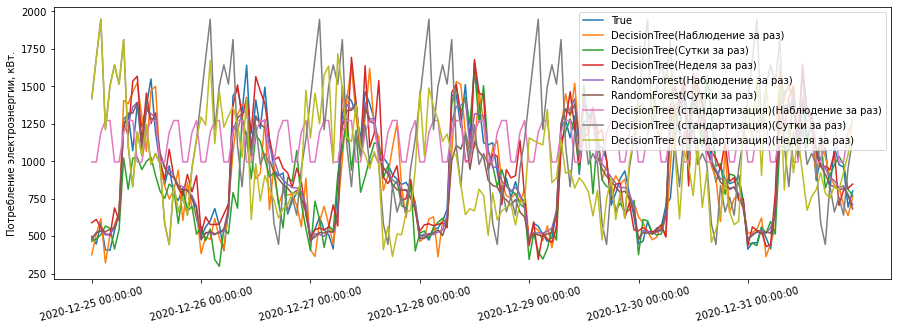

In [218]:
plt.figure(figsize=(15, 5))
for col in df_predictions.columns:
    plt.plot(df_predictions[col], label=col)
plt.ylabel('Потребление электроэнергии, кВт.')
plt.legend()
plt.xticks(ticks=range(0, 168, 24),labels=dates_list, rotation=15);

In [219]:
colors = sns.color_palette("bright", n_colors=len(df_predictions.columns))

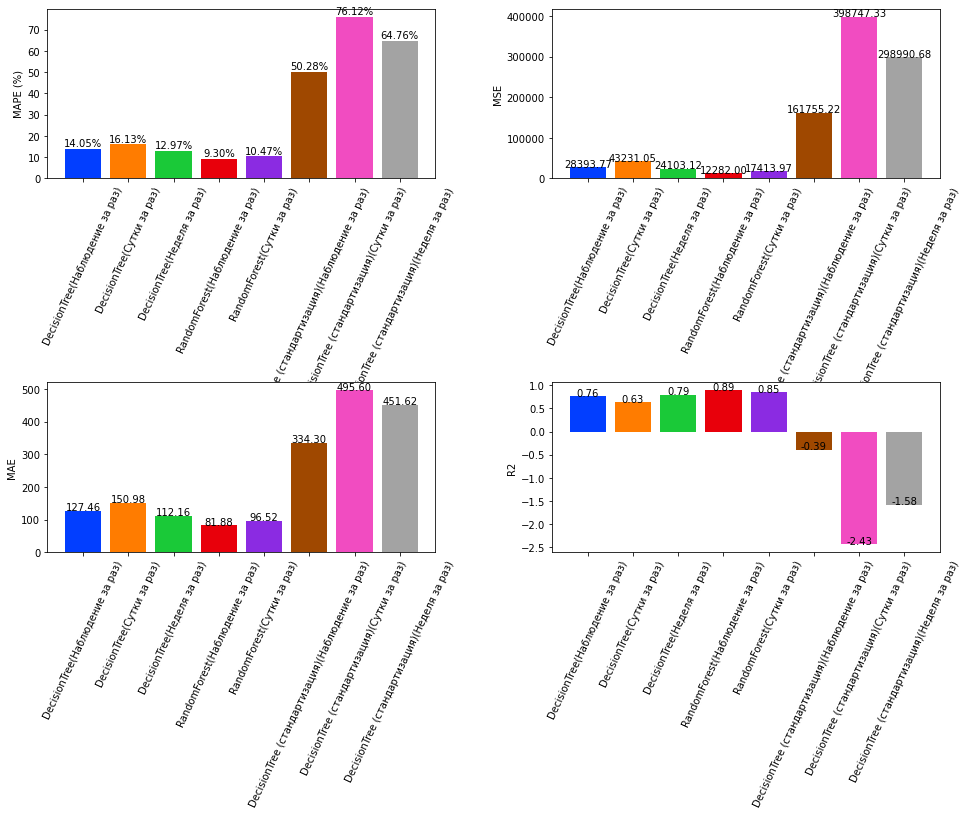

In [220]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=1.2, wspace=0.3) 

plt.subplot(2, 2, 1)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAPE'], color=colors)
for index, value in enumerate(df_results['MAPE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}%', ha='center')
plt.ylabel('MAPE (%)')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 2)
plt.bar(x=df_predictions.columns[1:], height=df_results['MSE'], color=colors)
for index, value in enumerate(df_results['MSE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MSE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 3)
plt.bar(x=df_predictions.columns[1:], height=df_results['MAE'], color=colors)
for index, value in enumerate(df_results['MAE']):
    plt.text(x=index, y=value + 1, s=f'{value:.2f}', ha='center')
plt.ylabel('MAE')
plt.xticks(df_predictions.columns[1:], rotation=65)

plt.subplot(2, 2, 4)
plt.bar(x=df_predictions.columns[1:], height=df_results['R2'], color=colors)
for index, value in enumerate(df_results['R2']):
    plt.text(x=index, y=value, s=f'{value:.2f}', ha='center')
plt.ylabel('R2')
plt.xticks(df_predictions.columns[1:], rotation=65);

# Нормализация

# DecisionTree

In [221]:
(np.max(y)-np.min(y))

1954.4302401935215

In [232]:
WINDOW = 24*7
Forecast_type = 'Наблюдение за раз'

# каждый день отдельно, в каждом дне по 1 наблюдению
# X=[data_0, ..., data_23] -> y=[data_24]
X_train, y_train = [], []
for i in range(0, len(y)-WINDOW):
    X_train.append((y[i:i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))
    y_train.append((y[i+WINDOW]-np.min(y))/(np.max(y)-np.min(y)))

In [224]:
model_name = 'DecisionTree (нормализация)'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [225]:
model = DecisionTreeRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [226]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    for i in range(24):
        new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1)).item()
        y_pred.append(new_y)
        X_for_prediction = np.append(X_for_prediction, new_y)
end_prediction = time.time()
y_pred = [x * (np.max(y) - np.min(y)) + np.min(y) for x in y_pred]
df_predictions[f'{model_name}({Forecast_type})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [227]:
df_results = df_results.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results

Model  Tuner  \
0                   DecisionTree(Наблюдение за раз)  False   
1                        DecisionTree(Сутки за раз)  False   
2                       DecisionTree(Неделя за раз)  False   
3                   RandomForest(Наблюдение за раз)  False   
4                        RandomForest(Сутки за раз)  False   
5  DecisionTree (стандартизация)(Наблюдение за раз)  False   
6       DecisionTree (стандартизация)(Сутки за раз)  False   
7      DecisionTree (стандартизация)(Неделя за раз)  False   
8    DecisionTree (нормализация)(Наблюдение за раз)  False   

                                              Params       MAPE  \
0  {'max_depth': None, 'max_leaf_nodes': None, 'm...  14.046990   
1  {'max_depth': None, 'max_leaf_nodes': None, 'm...  16.127943   
2  {'max_depth': None, 'max_leaf_nodes': None, 'm...  12.971834   
3  {'n_estimators': 100, 'max_depth': None, 'max_...   9.299245   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.469093   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  50.282337   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  76.122607   
7  {'max_depth': None, 'max_leaf_nodes': None, 'm...  64.760475   
8  {'max_depth': None, 'max_leaf_nodes': None, 'm...  53.446900   

             MSE         MAE        R2  Training_time Tuner_time  \
0   28393.766823  127.460416  0.755416      20.022319       None   
1   43231.052166  150.975916  0.627608      28.373121       None   
2   24103.124465  112.161936  0.792376     170.405692       None   
3   12282.000441   81.881064  0.894203     962.175953       None   
4   17413.969416   96.522142  0.849996    1976.314166       None   
5  161755.224270  334.300832 -0.393359      13.456223       None   
6  398747.332232  495.601467 -2.434809      46.887068       None   
7  298990.683946  451.623586 -1.575505     202.951359       None   
8  170566.829726  352.438594 -0.469263      15.797010       None   

   Time_prediction  
0         0.022014  
1         0.001998  
2         0.001000  
3         1.390336  
4         0.171177  
5         0.027239  
6         0.000000  
7         0.000000  
8         0.025001

In [236]:
df_results.to_csv('Trees_results.csv')
df_predictions.to_csv('Trees_predictions.csv')

# Доп признаки

In [9]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data.head()

Date     Time   Usage_kWh
0 2017-01-01  00 - 01  570.685479
1 2017-01-01  01 - 02  604.642705
2 2017-01-01  02 - 03  518.732113
3 2017-01-01  03 - 04  608.188829
4 2017-01-01  04 - 05  714.140572

## Peak

In [10]:
peak = []
for index, row in data.iterrows():
    if row.Time in ['06 - 07', '07 - 08', '08 - 09', '09 - 10', '10 - 11', '11 - 12', '12 - 13', '13 - 14']:
        peak.append(1)
    else:
        peak.append(0)
data['Peak'] = peak

In [11]:
y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [12]:
y[24], y25[0]

(array([361.33901367,   0.        ]), array([570.68547917,   0.        ]))

In [17]:
df_results2 = pd.DataFrame(None,
                      columns=['Model', 'Tuner', 'Params',
                               'MAPE', 'MSE', 'MAE', 'R2', #'Sum',
                               'Training_time', 'Tuner_time', 'Time_prediction'])
df_predictions2 = pd.DataFrame(None)
df_predictions2['True'] = y_test

In [18]:
WINDOW = 24*7
feature = '+peak'
params = {'n_estimators':100,
          'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'RandomForest'
Tuner = False

In [19]:
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

In [20]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 336))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [21]:
df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Model  Tuner  \
0  RandomForest(+peak)  False   

                                              Params      MAPE           MSE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.48698  16817.424798   

         MAE        R2  Training_time Tuner_time  Time_prediction  
0  96.741089  0.855135    1293.969913       None         0.086174

## Seasons

In [22]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+season'
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 24*7*4))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [23]:
df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Model  Tuner  \
0    RandomForest(+peak)  False   
1  RandomForest(+season)  False   

                                              Params       MAPE           MSE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980  16817.424798   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994  14755.975652   

         MAE        R2  Training_time Tuner_time  Time_prediction  
0  96.741089  0.855135    1293.969913       None         0.086174  
1  89.837962  0.872892    1837.463272       None         0.063428

## Month_mean

In [24]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
pivot_table = data.pivot_table(
    values='Usage_kWh', # столбец со значениями
    index=data['Date'].dt.month, # индексы - названия месяцев
    columns=data['Date'].dt.year, # столбцы - года
    aggfunc=np.mean # функция агрегации - сумма
)
month_mean = [pivot_table[row.Date.year][row.Date.month] for ind, row in data.iterrows()]
data['Month_mean'] = month_mean

In [25]:
y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+month_mean'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    

model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 24*7*2))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [26]:
df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Model  Tuner  \
0        RandomForest(+peak)  False   
1      RandomForest(+season)  False   
2  RandomForest(+month_mean)  False   

                                              Params       MAPE           MSE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980  16817.424798   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994  14755.975652   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437  15453.931762   

         MAE        R2  Training_time Tuner_time  Time_prediction  
0  96.741089  0.855135    1293.969913       None         0.086174  
1  89.837962  0.872892    1837.463272       None         0.063428  
2  92.032890  0.866880    2789.697496       None         0.134156

## Month_mean + seasons

In [27]:
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+season+month_mean'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, 24*7*5))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


In [28]:
df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Model  Tuner  \
0               RandomForest(+peak)  False   
1             RandomForest(+season)  False   
2         RandomForest(+month_mean)  False   
3  RandomForest(+season+month_mean)  False   

                                              Params       MAPE           MSE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980  16817.424798   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994  14755.975652   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437  15453.931762   
3  {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118  15465.749658   

         MAE        R2  Training_time Tuner_time  Time_prediction  
0  96.741089  0.855135    1293.969913       None         0.086174  
1  89.837962  0.872892    1837.463272       None         0.063428  
2  92.032890  0.866880    2789.697496       None         0.134156  
3  91.589696  0.866778    3141.574125       None         0.135363

# Декомпозиция

In [35]:
df = pd.DataFrame(None)
df['date'] = data[data['Date'] <= '2020-12-30']['Date']
df['target'] = data[data['Date'] <= '2020-12-30']['Usage_kWh']
df.head()

date      target
0 2017-01-01  570.685479
1 2017-01-01  604.642705
2 2017-01-01  518.732113
3 2017-01-01  608.188829
4 2017-01-01  714.140572

In [36]:
import statsmodels.api as sm

In [37]:
df.set_index('date', inplace=True)
df.head()

target
date                  
2017-01-01  570.685479
2017-01-01  604.642705
2017-01-01  518.732113
2017-01-01  608.188829
2017-01-01  714.140572

In [38]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

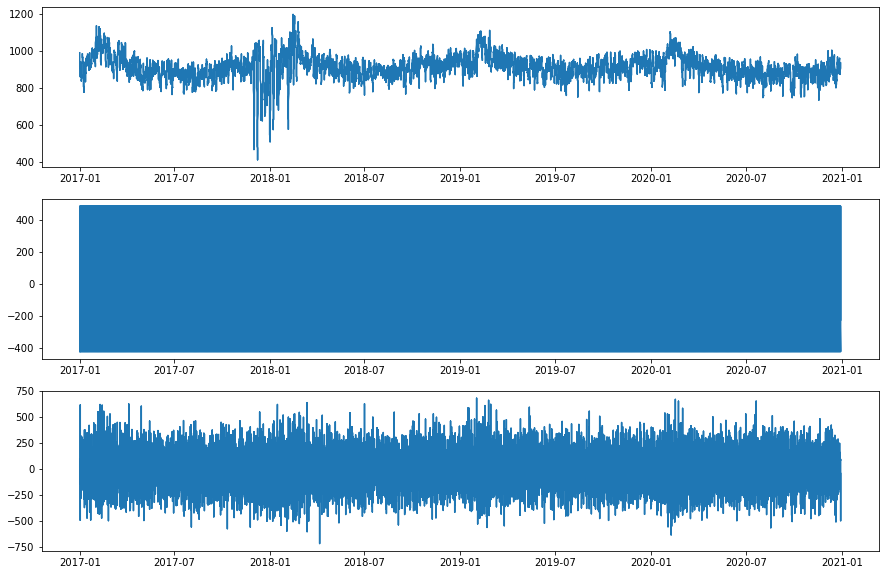

In [39]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(trend)
plt.subplot(3,1,2)
plt.plot(seasonal)
plt.subplot(3,1,3)
plt.plot(residual);

In [40]:
df_new = pd.DataFrame()
df_new['trend'] = trend
df_new['seasonal'] = seasonal
df_new['residual'] = residual
df_new['target'] = df['target']
df_new.dropna(inplace=True)

In [41]:
df_new.head()

trend    seasonal   residual       target
date                                                      
2017-01-01  991.970120  465.437976  35.648805  1493.056901
2017-01-01  984.714390  378.209143 -22.290660  1340.632872
2017-01-01  983.349617  361.705097  80.453591  1425.508305
2017-01-01  985.716328  142.416026  87.674266  1215.806620
2017-01-01  981.788014   57.463228  98.716260  1137.967502

In [42]:
y = df_new[df_new.index <= '2020-12-24'].values # до 24 вкл
y25 = df_new[df_new.index <= '2020-12-25'].values # до 25 вкл
y26 = df_new[df_new.index <= '2020-12-26'].values # до 26 вкл
y27 = df_new[df_new.index <= '2020-12-27'].values # до 27 вкл
y28 = df_new[df_new.index <= '2020-12-28'].values # до 28 вкл
y29 = df_new[df_new.index <= '2020-12-29'].values # до 29 вкл
y30 = df_new[df_new.index <= '2020-12-30'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

In [43]:
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'RandomForestRegressor (декомпозиция)'
params = {'max_depth': None,
            'max_leaf_nodes': None,
            'min_samples_leaf': 1,
            'min_samples_split': 2}
Tuner = False

In [44]:
y_train[0].shape

(24,)

In [45]:
X_train[0].shape

(672,)

In [46]:
model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

In [47]:
start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                RandomForest(+peak)  False   
1                              RandomForest(+season)  False   
2                          RandomForest(+month_mean)  False   
3                   RandomForest(+season+month_mean)  False   
4                            RandomForest(window=24)  False   
5  RandomForestRegressor (декомпозиция)(Сутки за ...  False   

                                              Params       MAPE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3  {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.350031   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   

             MSE         MAE        R2  Training_time Tuner_time  \
0   16817.424798   96.741089  0.855135    1293.969913       None   
1   14755.975652   89.837962  0.872892    1837.463272       None   
2   15453.931762   92.032890  0.866880    2789.697496       None   
3   15465.749658   91.589696  0.866778    3141.574125       None   
4   15815.711598   89.382204  0.863763     111.465292       None   
5  117026.514135  293.162931 -0.008066    5528.487760       None   

   Time_prediction  
0         0.086174  
1         0.063428  
2         0.134156  
3         0.135363  
4         1.878394  
5         0.483948

In [48]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

In [49]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл

y = ExponentialSmoothing(y).fit().fittedvalues
y25 = ExponentialSmoothing(y25).fit().fittedvalues
y26 = ExponentialSmoothing(y26).fit().fittedvalues
y27 = ExponentialSmoothing(y27).fit().fittedvalues
y28 = ExponentialSmoothing(y28).fit().fittedvalues
y29 = ExponentialSmoothing(y29).fit().fittedvalues
y30 = ExponentialSmoothing(y30).fit().fittedvalues

y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'RandomForestRegressor (ExponentialSmoothing)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                RandomForest(+peak)  False   
1                              RandomForest(+season)  False   
2                          RandomForest(+month_mean)  False   
3                   RandomForest(+season+month_mean)  False   
4                            RandomForest(window=24)  False   
5  RandomForestRegressor (декомпозиция)(Сутки за ...  False   
6  RandomForestRegressor (ExponentialSmoothing)(С...  False   

                                              Params       MAPE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3  {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.350031   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   

             MSE         MAE        R2  Training_time Tuner_time  \
0   16817.424798   96.741089  0.855135    1293.969913       None   
1   14755.975652   89.837962  0.872892    1837.463272       None   
2   15453.931762   92.032890  0.866880    2789.697496       None   
3   15465.749658   91.589696  0.866778    3141.574125       None   
4   15815.711598   89.382204  0.863763     111.465292       None   
5  117026.514135  293.162931 -0.008066    5528.487760       None   
6   45605.921319  145.236786  0.607151    1635.611406       None   

   Time_prediction  
0         0.086174  
1         0.063428  
2         0.134156  
3         0.135363  
4         1.878394  
5         0.483948  
6         0.059867

In [50]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'RandomForestRegressor (Weekday)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                RandomForest(+peak)  False   
1                              RandomForest(+season)  False   
2                          RandomForest(+month_mean)  False   
3                   RandomForest(+season+month_mean)  False   
4                            RandomForest(window=24)  False   
5  RandomForestRegressor (декомпозиция)(Сутки за ...  False   
6  RandomForestRegressor (ExponentialSmoothing)(С...  False   
7      RandomForestRegressor (Weekday)(Сутки за раз)  False   

                                              Params       MAPE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3  {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.350031   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
7  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   

             MSE         MAE        R2  Training_time Tuner_time  \
0   16817.424798   96.741089  0.855135    1293.969913       None   
1   14755.975652   89.837962  0.872892    1837.463272       None   
2   15453.931762   92.032890  0.866880    2789.697496       None   
3   15465.749658   91.589696  0.866778    3141.574125       None   
4   15815.711598   89.382204  0.863763     111.465292       None   
5  117026.514135  293.162931 -0.008066    5528.487760       None   
6   45605.921319  145.236786  0.607151    1635.611406       None   
7   14791.477838   89.741873  0.872586    1928.316648       None   

   Time_prediction  
0         0.086174  
1         0.063428  
2         0.134156  
3         0.135363  
4         1.878394  
5         0.483948  
6         0.059867  
7         0.127975

In [51]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
day_max = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].max()
day_min = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].min()
data['Day_max'] = [day_max[row.Date.weekday()] for i, row in data.iterrows()]
data['Day_min'] = [day_min[row.Date.weekday()] for i, row in data.iterrows()]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'RandomForestRegressor (Day_min_max)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                RandomForest(+peak)  False   
1                              RandomForest(+season)  False   
2                          RandomForest(+month_mean)  False   
3                   RandomForest(+season+month_mean)  False   
4                            RandomForest(window=24)  False   
5  RandomForestRegressor (декомпозиция)(Сутки за ...  False   
6  RandomForestRegressor (ExponentialSmoothing)(С...  False   
7      RandomForestRegressor (Weekday)(Сутки за раз)  False   
8  RandomForestRegressor (Day_min_max)(Сутки за раз)  False   

                                              Params       MAPE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3  {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.350031   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
7  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
8  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   

             MSE         MAE        R2  Training_time Tuner_time  \
0   16817.424798   96.741089  0.855135    1293.969913       None   
1   14755.975652   89.837962  0.872892    1837.463272       None   
2   15453.931762   92.032890  0.866880    2789.697496       None   
3   15465.749658   91.589696  0.866778    3141.574125       None   
4   15815.711598   89.382204  0.863763     111.465292       None   
5  117026.514135  293.162931 -0.008066    5528.487760       None   
6   45605.921319  145.236786  0.607151    1635.611406       None   
7   14791.477838   89.741873  0.872586    1928.316648       None   
8   14123.313283   87.753817  0.878342    2882.832672       None   

   Time_prediction  
0         0.086174  
1         0.063428  
2         0.134156  
3         0.135363  
4         1.878394  
5         0.483948  
6         0.059867  
7         0.127975  
8         0.135008

In [52]:
data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
Forecast_type = 'Сутки за раз'
model_name = 'RandomForestRegressor (Weekday+peak)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({Forecast_type})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                RandomForest(+peak)  False   
1                              RandomForest(+season)  False   
2                          RandomForest(+month_mean)  False   
3                   RandomForest(+season+month_mean)  False   
4                            RandomForest(window=24)  False   
5  RandomForestRegressor (декомпозиция)(Сутки за ...  False   
6  RandomForestRegressor (ExponentialSmoothing)(С...  False   
7      RandomForestRegressor (Weekday)(Сутки за раз)  False   
8  RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
9  RandomForestRegressor (Weekday+peak)(Сутки за ...  False   

                                              Params       MAPE  \
0  {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1  {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2  {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3  {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4  {'n_estimators': 100, 'max_depth': None, 'max_...  10.350031   
5  {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
6  {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
7  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
8  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
9  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   

             MSE         MAE        R2  Training_time Tuner_time  \
0   16817.424798   96.741089  0.855135    1293.969913       None   
1   14755.975652   89.837962  0.872892    1837.463272       None   
2   15453.931762   92.032890  0.866880    2789.697496       None   
3   15465.749658   91.589696  0.866778    3141.574125       None   
4   15815.711598   89.382204  0.863763     111.465292       None   
5  117026.514135  293.162931 -0.008066    5528.487760       None   
6   45605.921319  145.236786  0.607151    1635.611406       None   
7   14791.477838   89.741873  0.872586    1928.316648       None   
8   14123.313283   87.753817  0.878342    2882.832672       None   
9   15484.183340   92.444296  0.866619    5904.829086       None   

   Time_prediction  
0         0.086174  
1         0.063428  
2         0.134156  
3         0.135363  
4         1.878394  
5         0.483948  
6         0.059867  
7         0.127975  
8         0.135008  
9         0.431782

In [53]:
month_dict = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь'
}

meteo = pd.read_csv('meteo_data.txt',
                    delimiter='\t', header=None,
                    names=['temperature', 'humidity', 'wind_speed', 'clear', 'cloudy', 'overcast', 'rain', 'snow'])

t_list = []
h_list = []
w_list = []
for ind, row in meteo.iterrows():
    t = row.temperature.replace('°С', '')
    t = t.replace('−', '-')
    t = t.replace('+', '')
    t_list.append(float(t))
    
    h = row.humidity.replace(' %', '')
    h_list.append(int(h))
    
    w = row.wind_speed.replace(' м/с', '')
    w_list.append(w)
    
meteo['temperature'] = t_list
meteo['humidity'] = h_list
meteo['wind_speed'] = w_list

month_dict_ = {v:k for k, v in month_dict.items()}

meteo = meteo.rename(index=month_dict_)

meteo

temperature  humidity wind_speed  clear  cloudy  overcast  rain  snow
1          -9.0        86        3.6      2      20         6     1     1
2          -6.3        84        3.5      2      19         6     2     1
3          -2.2        78        3.4      7      17         4     2     1
4           3.9        67        3.2      9      15         4     2     0
5          10.8        62        3.2     10      15         4     1     0
6          15.8        64        2.9     12      14         3     0     0
7          17.7        74        2.5      9      17         3     0     0
8          16.2        76        2.7     11      16         2     1     0
9           9.8        84        3.1      7      17         5     1     0
10          3.8        85        3.4      5      18         5     1     1
11         -2.1        87        3.4      2      20         5     2     1
12         -5.9        88        3.5      2      19         7     1     1

In [54]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Month'] = data['Date'].dt.month

t = [meteo['temperature'][row.Month] for ind, row in data.iterrows()]
data['temperature'] = t 

t = [meteo['humidity'][row.Month] for ind, row in data.iterrows()]
data['humidity'] = t 

t = [meteo['wind_speed'][row.Month] for ind, row in data.iterrows()]
data['wind_speed'] = t 

t = [meteo['clear'][row.Month] for ind, row in data.iterrows()]
data['clear'] = t 

t = [meteo['cloudy'][row.Month] for ind, row in data.iterrows()]
data['cloudy'] = t 

t = [meteo['overcast'][row.Month] for ind, row in data.iterrows()]
data['overcast'] = t 

t = [meteo['rain'][row.Month] for ind, row in data.iterrows()]
data['rain'] = t 

t = [meteo['snow'][row.Month] for ind, row in data.iterrows()]
data['snow'] = t 

In [55]:
data = data.drop(['Month'], axis=1)

In [56]:
y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*7
feature = '+meteo'

Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = 'RandomForestRegressor'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-24*7:]
    new_y = model.predict(X_for_prediction[-24*7:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({feature})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4                             RandomForest(window=24)  False   
5   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
6   RandomForestRegressor (ExponentialSmoothing)(С...  False   
7       RandomForestRegressor (Weekday)(Сутки за раз)  False   
8   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
9   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
10                      RandomForestRegressor(+meteo)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'n_estimators': 100, 'max_depth': None, 'max_...  10.350031   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4    15815.711598   89.382204  0.863763     111.465292       None   
5   117026.514135  293.162931 -0.008066    5528.487760       None   
6    45605.921319  145.236786  0.607151    1635.611406       None   
7    14791.477838   89.741873  0.872586    1928.316648       None   
8    14123.313283   87.753817  0.878342    2882.832672       None   
9    15484.183340   92.444296  0.866619    5904.829086       None   
10   13934.399122   85.828651  0.879969    5727.496444       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          1.878394  
5          0.483948  
6          0.059867  
7          0.127975  
8          0.135008  
9          0.431782  
10         0.127657

In [118]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]

day_max = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].max()
day_min = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].min()
data['Day_max'] = [day_max[row.Date.weekday()] for i, row in data.iterrows()]
data['Day_min'] = [day_min[row.Date.weekday()] for i, row in data.iterrows()]


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]


WINDOW = 24*7
Forecast_type = 'Сутки за раз'
Tuner = False

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = f'RandomForest'
feature = '+Weekday+Day_min_max'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992

In [120]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])

day_max = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].max()
day_min = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].min()
data['Day_max'] = [day_max[row.Date.weekday()] for i, row in data.iterrows()]
data['Day_min'] = [day_min[row.Date.weekday()] for i, row in data.iterrows()]

data['Winter'] = [1 if m in [12,1,2] else 0_ for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]


WINDOW = 24*7
Forecast_type = 'Сутки за раз'
Tuner = False

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])
    
model_name = f'RandomForest'
feature = '+Day_min_max+meteo'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}({feature})',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992  
11         0.526765

In [121]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992  
11         0.526765  
12         0.076532

In [122]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*2
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992  
11         0.526765  
12         0.076532  
13         0.140013

In [123]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*3
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992  
11         0.526765  
12         0.076532  
13         0.140013  
14         0.350011

In [124]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*4
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   
15   12112.287954   83.570180  0.895665     843.985928       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992  
11         0.526765  
12         0.076532  
13         0.140013  
14         0.350011  
15         0.095303

In [125]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*5
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   
16                           RandomForest(window=120)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.252344   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   
15   12112.287954   83.570180  0.895665     843.985928       None   
16   11392.998677   82.029204  0.901861    1324.926885       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9          0.127657  
10         0.149992  
11         0.526765  
12         0.076532  
13         0.140013  
14         0.350011  
15         0.095303  
16         0.442034

In [126]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 24*6
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   
16                           RandomForest(window=120)  False   
17                           RandomForest(window=144)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.252344   
17  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.648523   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   
15   12112.287954   83.570180  0.895665     843.985928       None   
16   11392.998677   82.029204  0.901861    1324.926885       None   
17   12359.251600   85.493467  0.893537    1838.990504       None   

    Time_prediction  
0          0.086174  
1          0.063428  
2          0.134156  
3          0.135363  
4          0.483948  
5          0.059867  
6          0.127975  
7          0.135008  
8          0.431782  
9     

In [128]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
y = data[data['Date'] <= '2020-12-24']['Usage_kWh'].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25']['Usage_kWh'].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26']['Usage_kWh'].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27']['Usage_kWh'].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28']['Usage_kWh'].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29']['Usage_kWh'].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30']['Usage_kWh'].values # до 30 вкл
y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 96
Forecast_type = 'Сутки за раз'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW])
    y_train.append(y[i+WINDOW:i+WINDOW+24])
    
model_name = f'RandomForest(window={WINDOW})'
model = RandomForestRegressor()
start_training = time.time()
model.fit(np.array(X_train), y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()


df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   
16                           RandomForest(window=120)  False   
17                           RandomForest(window=144)  False   
18                            RandomForest(window=96)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.252344   
17  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.648523   
18  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.284736   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   
15   12112.287954   83.570180  0.895665     843.985928       None   
16   11392.998677   82.029204  0.901861    1324.926885       None   
17   12359.251600   85.493467  0.893537    1838.990504       None   
18   11095.699854   81.699611  0.904422    1146.709918       None   

    Time_prediction  
0  

In [129]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
day_max = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].max()
day_min = data.groupby(data['Date'].dt.weekday)['Usage_kWh'].min()
data['Day_max'] = [day_max[row.Date.weekday()] for i, row in data.iterrows()]
data['Day_min'] = [day_min[row.Date.weekday()] for i, row in data.iterrows()]

y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 120
Forecast_type = 'Сутки за раз'
model_name = 'RandomForest (Day_min_max, window=120)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   
16                           RandomForest(window=120)  False   
17                           RandomForest(window=144)  False   
18                            RandomForest(window=96)  False   
19             RandomForest (Day_min_max, window=120)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.252344   
17  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.648523   
18  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.284736   
19  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.400094   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   
15   12112.287954   83.570180  0.895665     843.985928       None   
16   11392.998677   82.029204  0.901861    1324.926885       None   
17   12359.251600   85.493467  0

In [131]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 120
Forecast_type = 'Сутки за раз'
model_name = 'RandomForest (seasons, window=120)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   
16                           RandomForest(window=120)  False   
17                           RandomForest(window=144)  False   
18                            RandomForest(window=96)  False   
19             RandomForest (Day_min_max, window=120)  False   
20                 RandomForest (seasons, window=120)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.252344   
17  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.648523   
18  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.284736   
19  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.400094   
20  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.204820   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     505.055036       None   
14   11892.505130   83.879044  0.897558     958.401173       None   
15   12112.287954   83.570180  0.89566

In [132]:
data = pd.read_csv('Харовсклеспром_data.csv', index_col=0, parse_dates=['Date'])
data['Winter'] = [1 if m in [12,1,2] else 0 for m in data['Date'].dt.month]
data['Summer'] = [1 if m in [6,7,8] else 0 for m in data['Date'].dt.month]
data['Fall'] = [1 if m in [9,10,11] else 0 for m in data['Date'].dt.month]

data['Monday'] = [1 if row.Date == 0 else 0 for index, row in data.iterrows()]
data['Tuesday'] = [1 if row.Date == 1 else 0 for index, row in data.iterrows()]
data['Wednesday'] = [1 if row.Date == 2 else 0 for index, row in data.iterrows()]
data['Thursday'] = [1 if row.Date == 3 else 0 for index, row in data.iterrows()]
data['Friday'] = [1 if row.Date == 4 else 0 for index, row in data.iterrows()]
data['Saturday'] = [1 if row.Date == 5 else 0 for index, row in data.iterrows()]


y = data[data['Date'] <= '2020-12-24'].iloc[:, 2:].values # до 24 вкл
y25 = data[data['Date'] <= '2020-12-25'].iloc[:, 2:].values # до 25 вкл
y26 = data[data['Date'] <= '2020-12-26'].iloc[:, 2:].values # до 26 вкл
y27 = data[data['Date'] <= '2020-12-27'].iloc[:, 2:].values# до 27 вкл
y28 = data[data['Date'] <= '2020-12-28'].iloc[:, 2:].values # до 28 вкл
y29 = data[data['Date'] <= '2020-12-29'].iloc[:, 2:].values # до 29 вкл
y30 = data[data['Date'] <= '2020-12-30'].iloc[:, 2:].values # до 30 вкл


y_list = [y, y25, y26, y27, y28, y29, y30]

WINDOW = 120
Forecast_type = 'Сутки за раз'
model_name = 'RandomForest (seasons, weekday, window=120)'

X_train, y_train = [], []
for i in range(0, len(y)-24*8):
    X_train.append(y[i:i+WINDOW].flatten())
    y_train.append(y[i+WINDOW:i+WINDOW+24][:, 0])

model = RandomForestRegressor()
start_training = time.time()
model.fit(X_train, y_train)
end_training = time.time()

start_prediction = time.time()
y_pred = []
for day in range(7):
    print(f'Day: {day+1}')
    X_for_prediction = y_list[day][-WINDOW:]
    new_y = model.predict(X_for_prediction[-WINDOW:].reshape(1, -1))[0]
    y_pred.extend(new_y)
end_prediction = time.time()
df_predictions2[f'{model_name}({Forecast_type})'] = y_pred

df_results2 = df_results2.append({'Model':f'{model_name}',
                        'Tuner':Tuner,
                        'Params': params,
                        'MAPE':mape(y_test, y_pred),
                        'MSE':mse(y_test, y_pred),
                        'MAE':mae(y_test, y_pred),
                        'R2':r2(y_test, y_pred),
                        #'Sum':sum(y_pred),
                        'Training_time':end_training-start_training,
                        'Tuner_time':None,
                        'Time_prediction':end_prediction-start_prediction},
                                                                ignore_index=True)
df_results2

Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
Day: 7


Model  Tuner  \
0                                 RandomForest(+peak)  False   
1                               RandomForest(+season)  False   
2                           RandomForest(+month_mean)  False   
3                    RandomForest(+season+month_mean)  False   
4   RandomForestRegressor (декомпозиция)(Сутки за ...  False   
5   RandomForestRegressor (ExponentialSmoothing)(С...  False   
6       RandomForestRegressor (Weekday)(Сутки за раз)  False   
7   RandomForestRegressor (Day_min_max)(Сутки за раз)  False   
8   RandomForestRegressor (Weekday+peak)(Сутки за ...  False   
9                       RandomForestRegressor(+meteo)  False   
10                 RandomForest(+Weekday+Day_min_max)  False   
11                   RandomForest(+Day_min_max+meteo)  False   
12                            RandomForest(window=24)  False   
13                            RandomForest(window=48)  False   
14                            RandomForest(window=72)  False   
15                            RandomForest(window=96)  False   
16                           RandomForest(window=120)  False   
17                           RandomForest(window=144)  False   
18                            RandomForest(window=96)  False   
19             RandomForest (Day_min_max, window=120)  False   
20                 RandomForest (seasons, window=120)  False   
21        RandomForest (seasons, weekday, window=120)  False   

                                               Params       MAPE  \
0   {'n_estimators': 100, 'max_depth': None, 'max_...  10.486980   
1   {'n_estimators': 100, 'max_depth': None, 'max_...   9.959994   
2   {'n_estimators': 100, 'max_depth': None, 'max_...  10.139437   
3   {'n_estimators': 100, 'max_depth': None, 'max_...  10.041118   
4   {'max_depth': None, 'max_leaf_nodes': None, 'm...  37.469634   
5   {'max_depth': None, 'max_leaf_nodes': None, 'm...  15.604154   
6   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.816322   
7   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.645502   
8   {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.138485   
9   {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.731870   
10  {'max_depth': None, 'max_leaf_nodes': None, 'm...  10.191279   
11  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.836327   
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.742900   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.310687   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.389635   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.479737   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.252344   
17  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.648523   
18  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.284736   
19  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.400094   
20  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.204820   
21  {'max_depth': None, 'max_leaf_nodes': None, 'm...   9.079022   

              MSE         MAE        R2  Training_time Tuner_time  \
0    16817.424798   96.741089  0.855135    1293.969913       None   
1    14755.975652   89.837962  0.872892    1837.463272       None   
2    15453.931762   92.032890  0.866880    2789.697496       None   
3    15465.749658   91.589696  0.866778    3141.574125       None   
4   117026.514135  293.162931 -0.008066    5528.487760       None   
5    45605.921319  145.236786  0.607151    1635.611406       None   
6    14791.477838   89.741873  0.872586    1928.316648       None   
7    14123.313283   87.753817  0.878342    2882.832672       None   
8    15484.183340   92.444296  0.866619    5904.829086       None   
9    13934.399122   85.828651  0.879969    5727.496444       None   
10   14927.788739   91.977574  0.871412    2897.115137       None   
11   16128.059437   90.021425  0.861073    4372.448235       None   
12   13350.619154   87.217700  0.884998     224.068148       None   
13   11751.002546   82.598195  0.898777     

In [133]:
df_results2.iloc[12:]

Model  Tuner  \
12                      RandomForest(window=24)  False   
13                      RandomForest(window=48)  False   
14                      RandomForest(window=72)  False   
15                      RandomForest(window=96)  False   
16                     RandomForest(window=120)  False   
17                     RandomForest(window=144)  False   
18                      RandomForest(window=96)  False   
19       RandomForest (Day_min_max, window=120)  False   
20           RandomForest (seasons, window=120)  False   
21  RandomForest (seasons, weekday, window=120)  False   

                                               Params      MAPE           MSE  \
12  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.742900  13350.619154   
13  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.310687  11751.002546   
14  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.389635  11892.505130   
15  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.479737  12112.287954   
16  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.252344  11392.998677   
17  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.648523  12359.251600   
18  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.284736  11095.699854   
19  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.400094  11946.433542   
20  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.204820  11722.651462   
21  {'max_depth': None, 'max_leaf_nodes': None, 'm...  9.079022  11129.510740   

          MAE        R2  Training_time Tuner_time  Time_prediction  
12  87.217700  0.884998     224.068148       None         0.076532  
13  82.598195  0.898777     505.055036       None         0.140013  
14  83.879044  0.897558     958.401173       None         0.350011  
15  83.570180  0.895665     843.985928       None         0.095303  
16  82.029204  0.901861    1324.926885       None         0.442034  
17  85.493467  0.893537    1838.990504       None         0.483414  
18  81.699611  0.904422    1146.709918       None         0.121009  
19  83.370697  0.897093    1862.016893       None         0.067815  
20  80.345143  0.899021    1930.621379       None         0.516465  
21  78.886332  0.904130    1972.090617       None         0.083265